In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mat
from scipy import stats
from ase import Atoms
from pymatgen.io import ase
import json
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('~/Downloads/Machine_Learning_Summer_2020/Formation_energies.txt',sep=' ',header=None)
data

,0,1,2,3,4,5,6
0,Ag_normal_N_0,=,6.1236,and,height,=,1.9851
1,Au_normal_N_0,=,5.8452,and,height,=,1.8299
2,Co_normal_N_0,=,0.1049,and,height,=,1.2745
3,Cr_normal_N_0,=,-4.0789,and,height,=,1.4257
4,Cu_normal_N_0,=,4.1861,and,height,=,1.4277
...,...,...,...,...,...,...,...
601,Ni_normal_P_3,=,-9.0417,and,height,=,1.3385
602,Zn_normal_P_3,=,-4.2966,and,height,=,3.5830
603,Mg_normal_S_3,=,-5.7633,and,height,=,4.7594
604,Ni_normal_S_3,=,-9.5083,and,height,=,1.8784


## Feature Engineering

In [3]:
columns_to_drop = [1,3,4,5]
column_names= {0:'Structure',2:'Formation Energy',6:'Height'}
data.drop(columns=columns_to_drop,inplace=True)
data.rename(columns=column_names,inplace=True)

In [4]:
structure = pd.Series(data=data.loc[:,'Structure'])
structure_details = structure.apply(lambda x: x.split(sep='_'))

In [5]:
data.loc[:,"Metal"] = structure_details.apply(lambda x: x[0])
data.loc[:,"Insertion Type"] = structure_details.apply(lambda x: x[1])
data.loc[:,"Element"] = structure_details.apply(lambda x: x[2])
data.loc[:,"Number"] = structure_details.apply(lambda x: x[3])
data.drop(axis=1,columns="Structure",inplace=True)

In [6]:
#Create 'atom' object for all the metals
atoms = pd.Series(data['Metal'].apply(lambda x: Atoms(x)))

In [7]:
#Instatiate 'AseAtomsAdaptor' object to convert 'atom' object to pymatgen 'molecule' object
converter = ase.AseAtomsAdaptor

In [8]:
#Create 'molecules' series for all the metals
molecules = pd.Series(atoms.apply(lambda x: converter.get_molecule(x)))

In [9]:
#Add features to the original dataframe
data.loc[:,'Group'] = molecules.apply(lambda x: x.species[0].group)
data.loc[:,'Atomic Number'] = molecules.apply(lambda x: x.species[0].Z)
data.loc[:,'Electronegativity'] = molecules.apply(lambda x: x.species[0].X)
data.loc[:,'Period'] = molecules.apply(lambda x: x.species[0].row)
data.loc[:,'Radius'] = molecules.apply(lambda x: x.species[0].atomic_radius)
data.loc[:,'Mass'] = molecules.apply(lambda x: x.species[0].atomic_mass)
data.loc[:,'Molar Volume'] = molecules.apply(lambda x: x.species[0].molar_volume)
data.loc[:,'Boiling Point'] = molecules.apply(lambda x: x.species[0].boiling_point)
data.loc[:,'Melting Point'] = molecules.apply(lambda x: x.species[0].melting_point)

In [10]:
#'for loop' to create an 'atomic density' feature
for i,mass,volume in zip(range(len(data['Mass'])),data['Mass'],data['Molar Volume']):
    data.loc[i,'Density'] = mass/volume

In [11]:
#open file containing surface energies of crystalline structures of metals
#ref='https://datadryad.org/stash/dataset/doi:10.5061/dryad.f2n6f'
with open('surfaces.json') as json_data:
    d = json.load(json_data)

Units for Surface Energy, Enthaply of Fusion and Ionization Energy is eV

In [12]:
#Create a Series of only one instance of each metal and a dictionary which will be filled with the metal and 
#the surface energies
metals = pd.Series(data['Metal'].unique())
surface_energies={}

In [13]:
#Fill dictionary with metals and respective average of surface energies of all polymorphs
for metal in metals:
    count=0
    surface_energy=0
    for molecule in d:
        if molecule['pretty_formula'] == metal:
            surface_energy += molecule['weighted_surface_energy']
            count+=1
    surface_energy /= count
    surface_energies["{}".format(metal)] = surface_energy

In [14]:
#Create dict containing the ionization energy of the metals
#ref='Kramida, A., Ralchenko, Yu., Reader, J., and NIST ASD Team (2019). NIST Atomic Spectra Database '
ionization_energies = {'Ag':7.576,'Au':9.225,'Co':7.881,'Cr':6.766,'Cu':7.726,'Fe':7.902,'Mn':7.434,'Pd':8.336,'Ti':6.828,'V':6.746,'Pt':8.958,'Li':5.392,'Be':9.322,'Na':5.139,'Al':5.986,'Ca':6.113,'Sc':6.561,'Ni':7.640,'Zn':9.394,'Ga':5.999,'K':4.341,'Mg':7.646}

In [15]:
#Create dict containing the heats of fusion of the metals
#ref='David R. Lide (ed), CRC Handbook of Chemistry and Physics, 84th Edition'
heats_of_fusion = {'Ag':11.28,'Au':12.72,'Co':16.06,'Cr':21.0,'Cu':13.26,'Fe':13.81,'Mn':12.91,'Pd':16.74,'Ti':14.15,'V':21.5,'Pt':22.17,'Li':3.00,'Be':7.89,'Na':2.60,'Al':10.79,'Ca':8.54,'Sc':14.1,'Ni':17.04,'Zn':7.07,'Ga':5.58,'K':2.33,'Mg':8.48}

In [16]:
#Add the 'surface energy' and 'enthalpy of fusion' features to the dataframe from the newly created dictionary
data['Surface Energy'] = data['Metal'].apply(lambda x: surface_energies.get(x))
data['Enthalpy of Fusion'] = data['Metal'].apply(lambda x: heats_of_fusion.get(x))
data['Enthalpy of Fusion'] = data['Enthalpy of Fusion'] * 0.01   #Unit conversion to eV
data['Ionization Energy'] = data['Metal'].apply(lambda x: ionization_energies.get(x))

## Feature Cleaning

#### All structures with metals 3.2 angstroms away from the average slab height were removed.

In [17]:
data = data[(data['Height']>-3.2)&(data['Height']<3.2)]
data.reset_index(inplace=True,drop=True)

In [18]:
#Create separate dataframes for the features and the targets
features = data.iloc[:,1:len(data.columns)]
target = data.iloc[:,0]
features.reset_index(drop=True,inplace=True)
target.reset_index(drop=True,inplace=True)

The two cells below convert the classification variables (metal,insertion type and element) into discrete integer values

In [19]:
metal_dict={}
for i,metal in enumerate(features['Metal'].unique()):
    metal_dict[i]=metal
features['Metal'] = features['Metal'].replace(metal_dict.values(),metal_dict.keys())

In [20]:
#The corresponding metal and integer values are shown below
print(metal_dict)

{0: 'Ag', 1: 'Au', 2: 'Co', 3: 'Cr', 4: 'Cu', 5: 'Fe', 6: 'Mn', 7: 'Pd', 8: 'Ti', 9: 'V', 10: 'Pt', 11: 'Li', 12: 'Be', 13: 'Na', 14: 'Al', 15: 'Ca', 16: 'Sc', 17: 'Ni', 18: 'Zn', 19: 'Ga', 20: 'K', 21: 'Mg'}


In [21]:
insert_dict={0:'normal',1:'pentagonic'}
element_dict={0:'N',1:'P',2:'S',3:'O'}
features['Insertion Type'] = features['Insertion Type'].replace(insert_dict.values(),insert_dict.keys())
features['Element'] = features['Element'].replace(element_dict.values(),element_dict.keys())

In [22]:
#Round the values with many decimal places
for i in range(len(features)):
    features['Mass']=round(features['Mass'][i],3)
    features['Density']=round(features['Density'][i],3)
    features['Surface Energy'] = round(features['Surface Energy'][i],4)

## PCA and Dimensionality Reduction

In [23]:
#Create a new dataframe only with continuous features
features_no_classif = features.drop(labels=['Metal','Insertion Type','Element'],axis=1)

In [24]:
#Train-Test split of 20% in test group
x_train_no_classif, x_test_no_classif, y_train_no_classif, y_test_no_classif = train_test_split(features_no_classif,target,test_size=0.2,random_state=0)

In [25]:
# Done to keep track of classification variables like element, insertion type and metal
# These are the indices from the original dataframe 'data'
x_train_indices = x_train_no_classif.index.to_list()
y_train_indices = y_train_no_classif.index.to_list()

In [26]:
#Create a dataframe with the classification variables called 'test_df'
arr = [i for i,column in enumerate(data.columns) if column=='Metal' or column=='Element' or column=='Insertion Type']
test_df = pd.DataFrame(index=x_train_indices,data=data.iloc[x_train_indices,arr])

#### StandardScaler scales the data s.t. every feature is centered around it's mean and scaled to unit variance

It is done independently on every feature

In [27]:
scaler=StandardScaler()

In [28]:
scaler.fit(x_train_no_classif)

StandardScaler()

In [29]:
x_train_no_classif=scaler.transform(x_train_no_classif)
x_test_no_classif=scaler.transform(x_test_no_classif)

In [30]:
num_columns=x_train_no_classif.shape[1]
print("The training set has a shape of: {}".format(x_train_no_classif.shape))

The training set has a shape of: (474, 15)


#### The plot below shows how much variance is retained as a function of the number of PCA components 

The Red Horizontal Line shows the 90% variance threshold
and the red vertical Line shows the minimum number of PCA's to achieve 90% retained variance

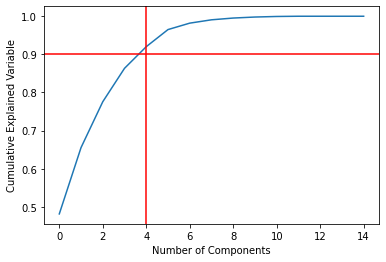

In [31]:
pca_test=PCA().fit(x_train_no_classif)
x_range=np.arange(0,num_columns,step=1)
y_values=np.cumsum(pca_test.explained_variance_ratio_)
x_at_90 = y_values[y_values>0.9][0]
x_at_90_index = np.where(y_values==x_at_90)
mat.plot(x_range,y_values)
mat.xlabel('Number of Components')
mat.ylabel('Cumulative Explained Variable')
mat.axhline(y=0.9,color='r')
mat.axvline(x=x_at_90_index[0][0],color='r')

In [32]:
pca_test=PCA(0.9) #This chooses the minimum number of components s.t. 90% of the variance is retained

In [33]:
pca_test.fit(x_train_no_classif)

PCA(n_components=0.9)

In [34]:
x_train_no_classif=pca_test.transform(x_train_no_classif)
x_test_no_classif=pca_test.transform(x_test_no_classif)

In [35]:
#Shows that x_train abd x_test are arrays of 474 instances with 5 columns, each representing a principal component
print("Shape of x_train is: {}".format(x_train_no_classif.shape))
print("Shape of x_test is: {}".format(x_test_no_classif.shape))

Shape of x_train is: (474, 5)
Shape of x_test is: (119, 5)


In [36]:
#Add the training set of features to 'test_df' after centering with StandardScaler and transforming the values
for i in range(0,x_train_no_classif.shape[1]):
    test_df['PCA {}'.format(i+1)]=x_train_no_classif[:,i]

In [37]:
#Add the target 'Formation Energy' into 'test_df'
test_df['Formation Energy'] = y_train_no_classif

In [38]:
sns.set_palette("Paired",n_colors=len(test_df['Metal']))

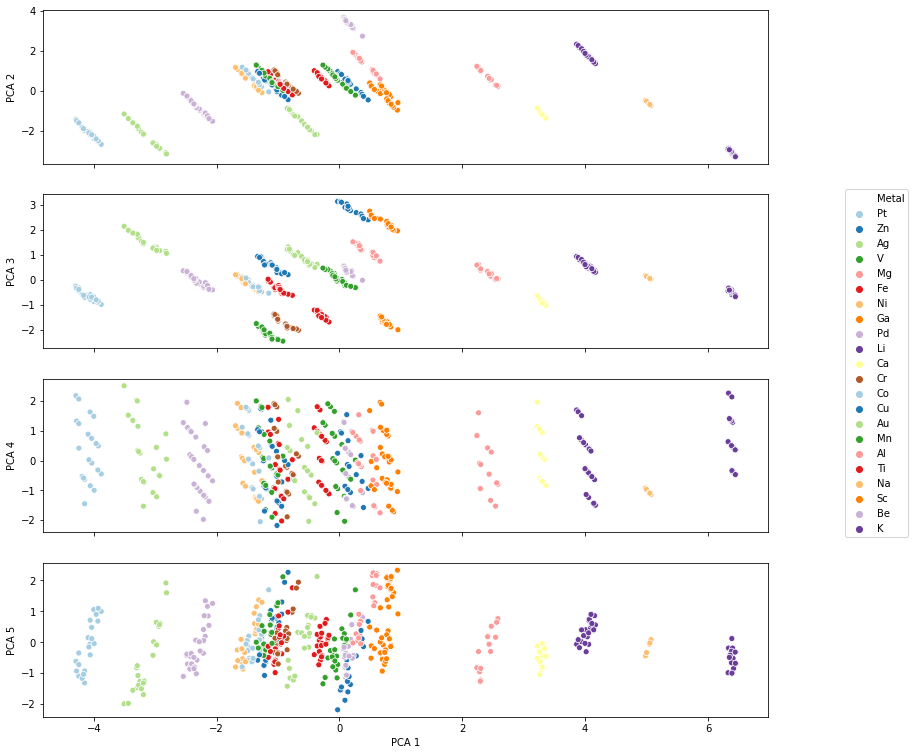

In [39]:
fig, (a,b,c,d) = mat.subplots(4,1,sharex=True)
fig.set_figheight(13)
fig.set_figwidth(13)
sns.scatterplot(x='PCA 1',y='PCA 2',data=test_df,ax=a,hue='Metal',legend=False)
sns.scatterplot(x='PCA 1',y='PCA 3',data=test_df,ax=b,hue='Metal',legend=False)
sns.scatterplot(x='PCA 1',y='PCA 4',data=test_df,ax=c,hue='Metal',legend=False)
g = sns.scatterplot(x='PCA 1',y='PCA 5',data=test_df,ax=d,hue='Metal')
g.legend(loc='right',bbox_to_anchor=(1.2,2.3))

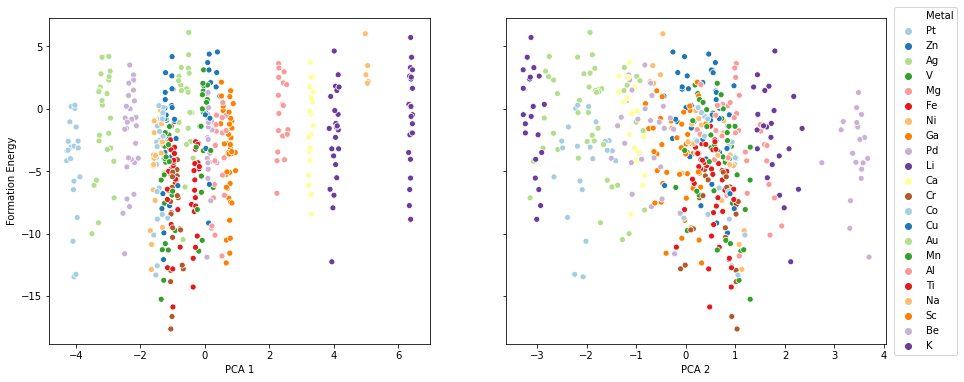

In [40]:
fig, (a,b) = mat.subplots(1,2,sharey=True)
fig.set_figheight(6)
fig.set_figwidth(15)
sns.scatterplot(x='PCA 1',y='Formation Energy',data=test_df,ax=a,hue='Metal',legend=False)
g = sns.scatterplot(x='PCA 2',y='Formation Energy',data=test_df,ax=b,hue='Metal')
g.legend(loc='right',bbox_to_anchor=(1.2,0.5))

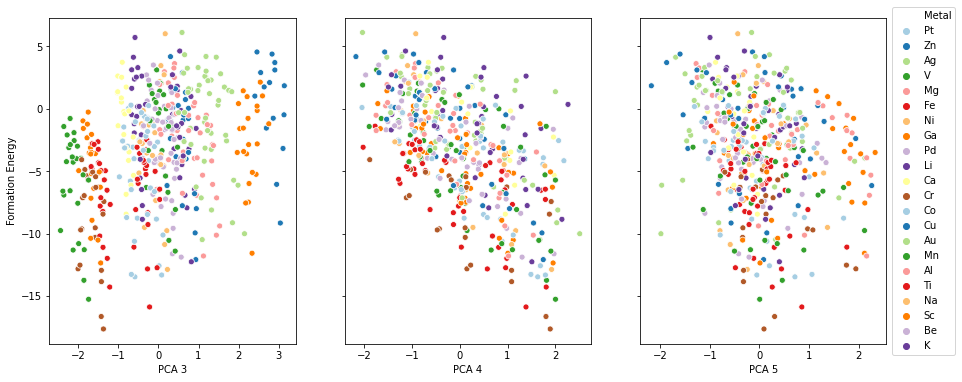

In [41]:
fig, (a,b,c) = mat.subplots(1,3,sharey=True)
fig.set_figheight(6)
fig.set_figwidth(15)
sns.scatterplot(x='PCA 3',y='Formation Energy',data=test_df,ax=a,hue='Metal',legend=False)
sns.scatterplot(x='PCA 4',y='Formation Energy',data=test_df,ax=b,hue='Metal',legend=False)
g = sns.scatterplot(x='PCA 5',y='Formation Energy',data=test_df,ax=c,hue='Metal')
g.legend(loc='right',bbox_to_anchor=(1.3,0.5))

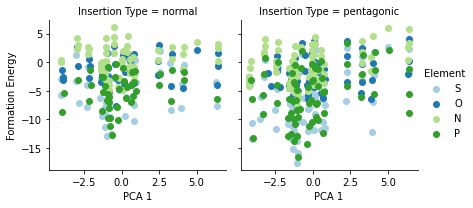

In [61]:
c = sns.FacetGrid(test_df,col='Insertion Type',hue='Element')
c.map(mat.scatter,"PCA 1","Formation Energy")
c.add_legend()

### Heat Map below shows how every feature affects the principal components 

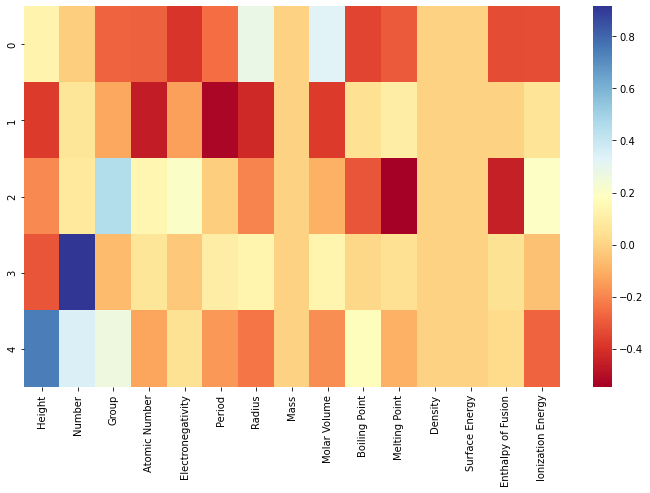

In [42]:
map_1=pd.DataFrame(pca_test.components_,columns=features_no_classif.columns)
mat.figure(figsize=(12,7))
sns.heatmap(map_1,cmap='RdYlBu')

In [43]:
lin_reg = LinearRegression()

In [44]:
lin_reg.fit(x_train_no_classif,y_train_no_classif)

LinearRegression()

In [45]:
y_pred = lin_reg.predict(x_test_no_classif)

In [46]:
lin_reg.score(x_test_no_classif,y_test_no_classif)

0.5460123157906138

In [47]:
MAE = mean_absolute_error(y_pred,y_test_no_classif)
MAE

2.4978311869215384

In [48]:
ridge = Ridge()

In [49]:
ridge.fit(x_train_no_classif,y_train_no_classif)

Ridge()

In [50]:
y_pred_ridge = ridge.predict(x_test_no_classif)

In [52]:
ridge.score(x_test_no_classif,y_test_no_classif)

0.5460256779139097

In [51]:
MAE_ridge = mean_absolute_error(y_pred_ridge,y_test_no_classif)
MAE_ridge

2.497582413556807

In [68]:
tree_1 = DecisionTreeRegressor()
tree_1.fit(x_train_no_classif,y_train_no_classif)

DecisionTreeRegressor()

In [69]:
tree_1.tree_.max_depth

18

In [70]:
y_pred_tree_1 = tree_1.predict(x_test_no_classif)

In [72]:
MAE_tree_1 = mean_absolute_error(y_pred_tree_1,y_test_no_classif)
MAE_tree_1

3.2044134453781505

In [84]:
y_test_arr = y_test_no_classif.to_numpy(dtype=float)

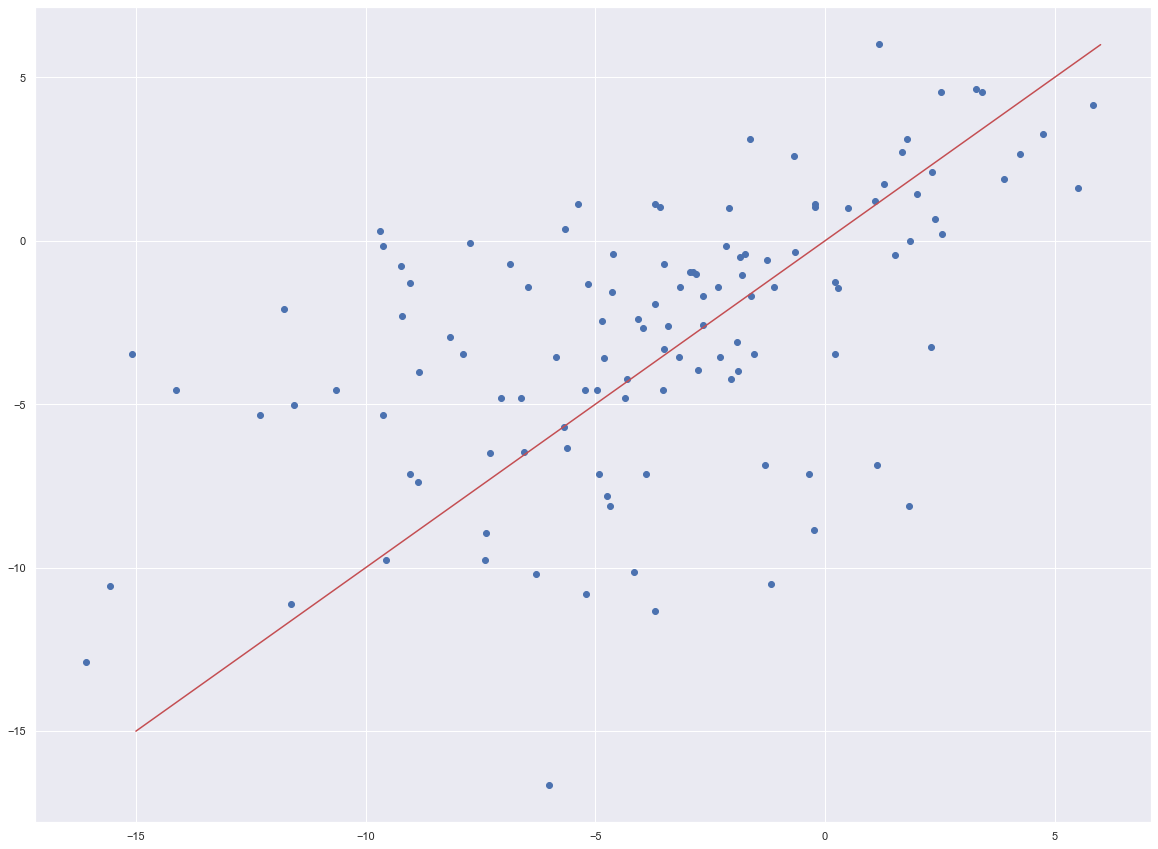

In [174]:
fig,a = mat.subplots(1,1)
a.figsize=(10,10)
a.plot(x_plot,y_plot,color='r')
a.scatter(y_test_arr,y_pred_tree_1)

## Statistical Analysis of Target Feature (Formation Energy)

##### Kurtosis is a measure of peakedness and skew is a measure of the symmetry. 
##### Values for either descriptor outside of the range -1 and 1 indicate significant error. Values between -0.5 and 0.5 are considered reasonable

In [17]:
print('skew is:',data['Formation Energy'].skew())
print('kurtosis is:',data['Formation Energy'].kurt())

skew is: -0.49924517356344356
kurtosis is: 0.011712186492339516


Kurtosis is within the acceptable range, however the skewness is too close to -1.

In [18]:
data['Formation Energy'].describe()

count    606.000000
mean      -3.344653
std        4.386652
min      -17.653900
25%       -6.057300
50%       -2.971050
75%       -0.245200
max        6.123600
Name: Formation Energy, dtype: float64

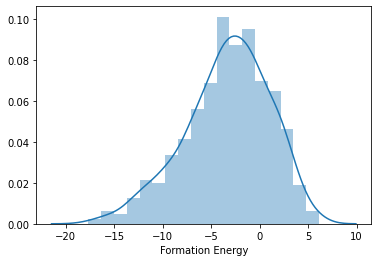

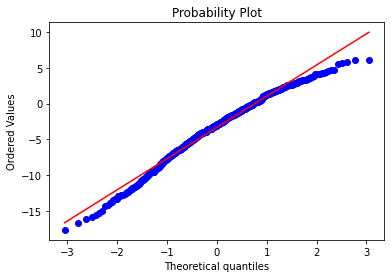

In [19]:
sns.distplot(data['Formation Energy'])
fig = mat.figure()
res = stats.probplot(data['Formation Energy'],plot=mat)

 A perfectly normal distribution would follow the theoretical red line perfectly in the probability plot above.

As demonstrated by the skewness value and the distribution plot above, our target variable 'Formation Energy' is significantly skewed to the left.

# MIGHT NOT REMOVE OUTLIERS (REMOVE BEST EFORMS)

#### To remove the datasets' outliers, the inter quartile range (IQR) was found and all values below Q1-1.5*IQR and above Q3+1.5*IQR were removed.

In [182]:
form_energy = pd.Series(data['Formation Energy'])
q1 = form_energy.quantile(0.25)
q2 = form_energy.quantile(0.5)
q3 = form_energy.quantile(0.75)
IQR = q3-q1
lower_bound = q1 - 1.5*IQR
upper_bound = q3 + 1.5*IQR
data = data[(data['Formation Energy']<upper_bound)&(data['Formation Energy']>lower_bound)]

#### Use certain normality test to quantitatively and definitevely determine if distribution is normal or not

In [21]:
stat,p=stats.shapiro(data['Formation Energy'])
if p>0.05:
    print('Dataset follows normal distribution')
else:
    print('P-value is smaller than alpha of 0.05. Fail to Reject Null Hypothesis\nDataset is NOT normal')

P-value is smaller than alpha of 0.05. Fail to Reject Null Hypothesis
Dataset is NOT normal


In [22]:
stat,p=stats.normaltest(data['Formation Energy'])
if p>0.05:
    print('Dataset follows normal distribution')
else:
    print('P-value is smaller than alpha of 0.05. Fail to Reject Null Hypothesis\nDataset is NOT normal')

P-value is smaller than alpha of 0.05. Fail to Reject Null Hypothesis
Dataset is NOT normal


Anderson-Darling Test below can be used to test against any type of distribution

In [23]:
result = stats.anderson(data['Formation Energy'],dist='gumbel_l')
stat = result.statistic
gumbel=False
for i in range(len(result.critical_values)):
    if result.critical_values[i] > stat:
        gumbel=True
if gumbel:
    print("At least one critical value is greater than the anderson stat.\nThe distribution follows gumbel type 1 distribution.")

In [24]:
mat.rcParams['figure.figsize'] = 7,7     #Resize subsequent figures

#### Assure the distribution follows the Type 1 Gumbel distribution using graphing techniques

Text(0.5, 1.0, 'Gumbel Type 1 fit on Formation Energy')

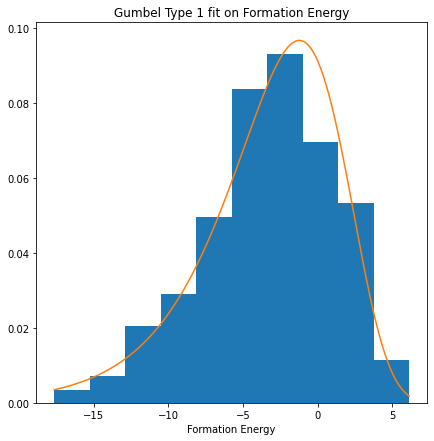

In [25]:
x = np.linspace(data['Formation Energy'].min(),data['Formation Energy'].max(),593)
mat.hist(data['Formation Energy'],density=True)
loc,scale= stats.gumbel_l.fit(data['Formation Energy'])
mat.plot(x,stats.gumbel_l(loc,scale).pdf(x))
mat.xlabel('Formation Energy')
mat.title('Gumbel Type 1 fit on Formation Energy')

In [26]:
mean_form_energy = data['Formation Energy'].mean()
std_form_energy= data['Formation Energy'].std()
print(mean_form_energy,std_form_energy)

-3.333742495784149 4.41677174865054


In [27]:
mat.rcParams['figure.figsize'] = 14,7     #Resize subsequent figures

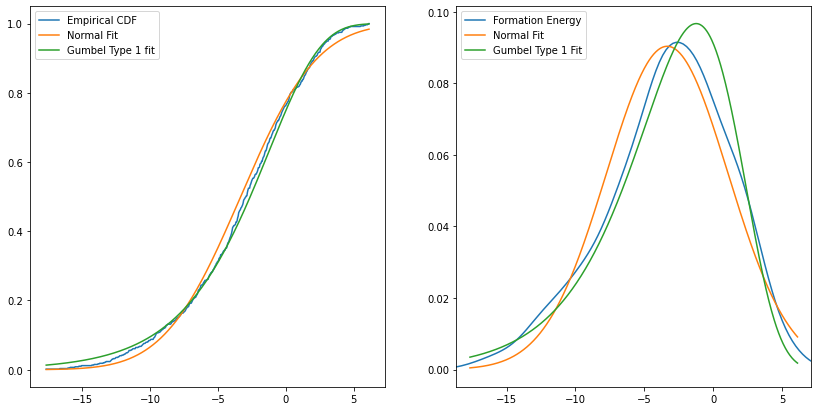

In [28]:
ecdf = sm.distributions.ECDF(data['Formation Energy'])
fig,(a,b) = mat.subplots(1,2)
a.plot(x,ecdf(x),label='Empirical CDF')
a.plot(x,stats.norm(mean_form_energy,std_form_energy).cdf(x),label='Normal Fit')
a.plot(x,stats.gumbel_l(loc,scale).cdf(x),label='Gumbel Type 1 fit')
sns.kdeplot(data['Formation Energy'],ax=b)
b.plot(x,stats.norm(mean_form_energy,std_form_energy).pdf(x),label='Normal Fit')
b.plot(x,stats.gumbel_l(loc,scale).pdf(x),label='Gumbel Type 1 Fit')
b.set_xlim([data['Formation Energy'].min()-1,data['Formation Energy'].max()+1])
b.legend()
a.legend()
#mat.xlabel('Formation Energy')
#mat.title('Formation Energy Cumulative Distribution Function')

### The kolmogorov-smirnov test was used below

######  It is a goodness of fit test and determines if the sample data is taken from a certain statistical distribution or not 

Found the absolute difference between the empirical data (our sample data) and the gumbel left distribution

In [29]:
absolute_differences_gumbel = np.abs(ecdf(x)-stats.gumbel_l(loc,scale).cdf(x))
absolute_differences_norm = np.abs(ecdf(x)-stats.norm(mean_form_energy,std_form_energy).cdf(x))
print(max(absolute_differences_gumbel),max(absolute_differences_norm))

0.03578275931246966 0.0557401006725336


Given a test-vaue of < 3%, we can safely assume our sampled data is taken from a gumbel left distribution

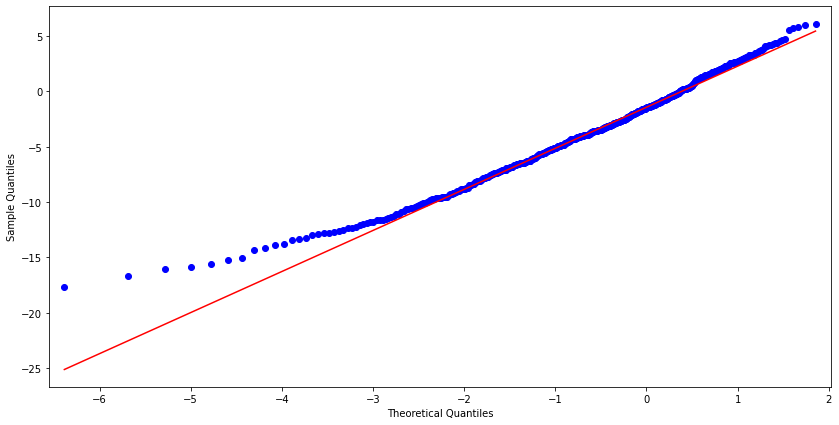

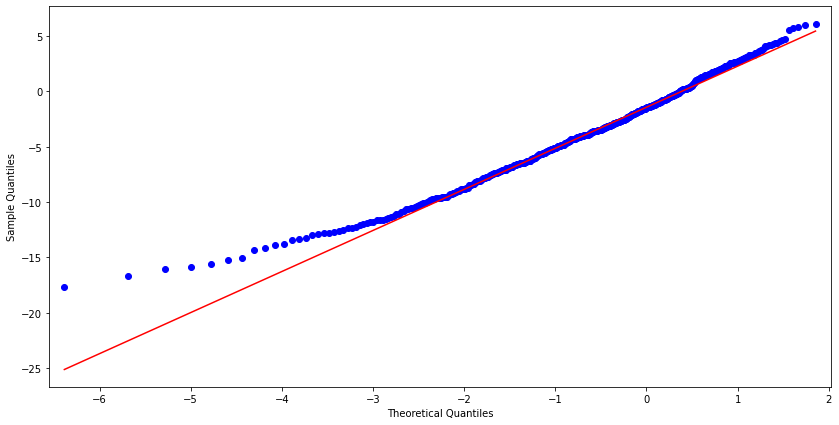

In [30]:
sm.graphics.qqplot(data['Formation Energy'],line='q',dist=stats.gumbel_l)

In [31]:
def convert_to_int(value):
    if value == 'normal':
        return 0
    elif value == 'pentagonic':
        return 1
    else:
        return value

In [32]:
data.loc[:,'Insertion Type'] = data['Insertion Type'].apply(lambda x: convert_to_int(x))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


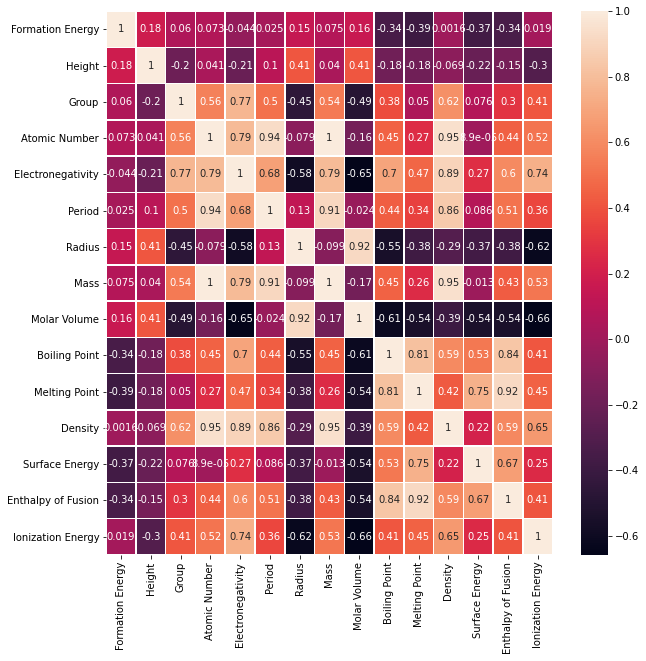

In [31]:
mat.subplots(figsize=(10,10))
corrmat = data.corr()
sns.heatmap(corrmat,annot=True,linewidths=0.5)

In [53]:
mat.rcParams['figure.figsize'] = 11,14

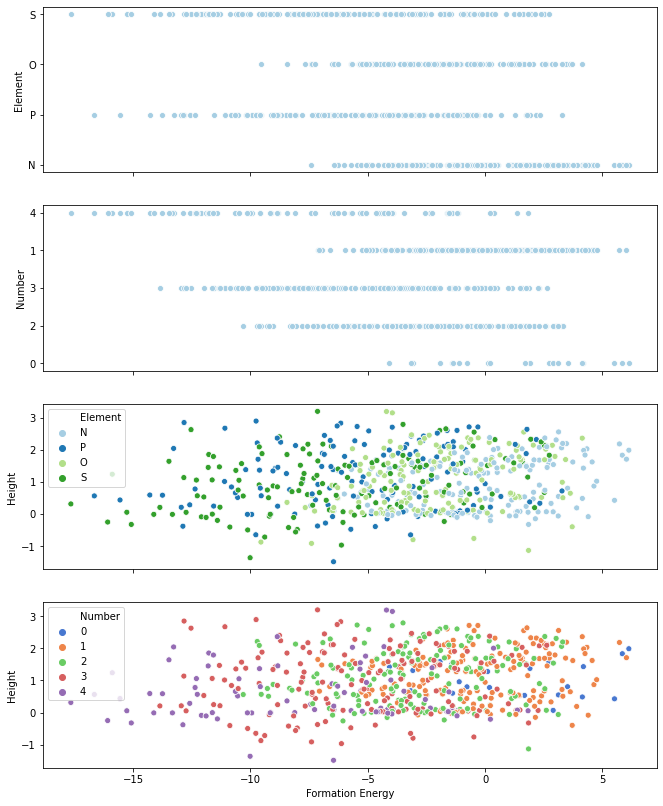

In [54]:
fig, (a,b,c,d) = mat.subplots(4,1,sharex=True)
sns.scatterplot(x='Formation Energy',y='Element',data=data,ax=a)
sns.scatterplot(x='Formation Energy',y='Number',data=data,ax=b)
sns.scatterplot(x='Formation Energy',y='Height',hue='Element',data=data,ax=c)
sns.scatterplot(x='Formation Energy',y='Height',hue='Number',data=data,ax=d,palette='muted')

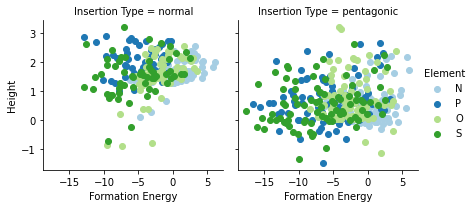

In [55]:
normal_insertion = data[data["Insertion Type"]=='normal']
c = sns.FacetGrid(data,col='Insertion Type',hue='Element')
c.map(mat.scatter,"Formation Energy","Height")
c.add_legend()